In [49]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def gibbs_bayesB(X, X_f, y, num_iterations, nu_e, S_e, nu_j, S_j, a, b, pi_initial, epsilon=1e-8):
    n, p = X.shape
    q = X_f.shape[1]
    
    # 初始化参数
    beta_f = np.zeros(q)      # 固定效应的初始值
    beta = np.zeros(p)        # SNP 效应的初始值
    sigma_e2 = 1.0            # 残差方差
    sigma_j2 = np.ones(p)     # 每个 SNP 的方差
    pi_param = pi_initial     # 稀疏性参数初始值
    delta = np.random.binomial(1, pi_param, p)  # 稀疏性指示变量的初始值
    
    # 用来存储采样的参数
    beta_f_samples = np.zeros((num_iterations, q))
    beta_samples = np.zeros((num_iterations, p))
    sigma_e2_samples = np.zeros(num_iterations)
    sigma_j2_samples = np.zeros((num_iterations, p))
    pi_samples = np.zeros(num_iterations)
    
    # 预计算 X_f^T X_f
    X_fT_X_f = X_f.T @ X_f
    
    for it in range(num_iterations):
        # Step 1: 更新固定效应 beta_f
        # 假设 beta_f ~ N(0, V_beta_f)
        # 需要定义 V_beta_f，假设为固定的先验方差矩阵
        # 这里假设 V_beta_f = tau_f^2 * I, tau_f^2 可以设置为一个大值表示弱先验
        tau_f2 = 1e6
        V_beta_f_inv = X_fT_X_f / sigma_e2 + np.eye(q) / tau_f2
        V_beta_f = np.linalg.inv(V_beta_f_inv)
        beta_f_mean = V_beta_f @ (X_f.T @ (y - X @ beta)) / sigma_e2
        beta_f = np.random.multivariate_normal(beta_f_mean, V_beta_f)
        
        # Step 2: 更新 SNP 效应 beta
        # 采用向量化更新的方法
        # 仅更新 delta_j = 1 的 beta_j
        active_indices = np.where(delta == 1)[0]
        if len(active_indices) > 0:
            X_active = X[:, active_indices]  # n x k
            sigma_j2_active = sigma_j2[active_indices]  # k
            # 计算协方差矩阵的对角元素
            Sigma_beta_inv = (X_active.T @ X_active) / sigma_e2 + np.diag(1 / sigma_j2_active)
            Sigma_beta = np.linalg.inv(Sigma_beta_inv)
            # 计算均值向量
            mu_beta = Sigma_beta @ (X_active.T @ (y - X_f @ beta_f)) / sigma_e2
            # 采样 beta_active
            beta_active = np.random.multivariate_normal(mu_beta, Sigma_beta)
            beta[active_indices] = beta_active
        # 非活跃的 beta_j 已经被设为 0，无需处理
        
        # Step 3: 更新 SNP 效应方差 sigma_j2
        # 仅更新 delta_j = 1 的 sigma_j2
        if len(active_indices) > 0:
            beta_active = beta[active_indices]
            shape_j = (nu_j + 1) / 2
            scale_j = (nu_j * S_j + beta_active ** 2) / 2  # 注意 Gamma 的 scale 是 theta = 1 / rate
            sigma_j2[active_indices] = 1 / np.random.gamma(shape_j, 1 / scale_j)
        
        # Step 4: 更新残差方差 sigma_e2
        residual = y - X_f @ beta_f - X @ beta
        shape_e = (n + nu_e) / 2
        scale_e = (residual.T @ residual + S_e) / 2
        sigma_e2 = 1 / np.random.gamma(shape_e, 1 / scale_e)
        
        # Step 5: 更新稀疏性参数 pi
        k = np.sum(delta)  # 非零的 beta_j 的数量
        pi_param = np.random.beta(a + k, b + p - k)
        
        # Step 6: 更新指示变量 delta
        # 使用向量化方法计算概率
        # prob_nonzero = pi * N(beta_j | 0, sigma_j2[j])
        # prob_zero = 1 - pi
        # delta_j ~ Bernoulli(prob_nonzero / (prob_nonzero + prob_zero))
        
        # 由于当 delta_j = 0 时，beta_j = 0，因此可以重新计算 beta[j] = 0 时的概率
        # 但是在当前步骤中，beta[j] 已经被更新，因此需要重新考虑
        
        # 计算 log 概率以避免下溢
        log_prob_nonzero = np.log(pi_param + epsilon) + stats.norm.logpdf(beta, 0, np.sqrt(sigma_j2) + epsilon)
        log_prob_zero = np.log(1 - pi_param + epsilon) + stats.norm.logpdf(beta, 0, epsilon)  # delta_j=0 implies beta_j=0
        max_log_prob = np.maximum(log_prob_nonzero, log_prob_zero)
        prob_nonzero = np.exp(log_prob_nonzero - max_log_prob)
        prob_zero = np.exp(log_prob_zero - max_log_prob)
        delta_prob = prob_nonzero / (prob_nonzero + prob_zero + epsilon)
        delta = np.random.binomial(1, delta_prob)
        # 将 delta_j = 0 的 beta_j 设为 0
        beta[delta == 0] = 0
        
        # 存储结果
        beta_f_samples[it, :] = beta_f
        beta_samples[it, :] = beta
        sigma_e2_samples[it] = sigma_e2
        sigma_j2_samples[it, :] = sigma_j2
        pi_samples[it] = pi_param
        
    return beta_f_samples, beta_samples, sigma_e2_samples, sigma_j2_samples, pi_samples


In [50]:
def simulate_data(n_samples, n_fixed_effects, n_snps, true_pi=0.5, true_sigma_e2=1.0):
    # 固定效应的设计矩阵 X_f 和 SNP 标记的设计矩阵 X
    X_f = np.random.randn(n_samples, n_fixed_effects)
    X = np.random.randn(n_samples, n_snps)
    
    # 真实的固定效应参数和 SNP 效应参数
    true_beta_f = np.random.randn(n_fixed_effects)
    true_beta = np.random.randn(n_snps) * np.random.binomial(1, true_pi, size=n_snps)  # 稀疏性
    
    # 残差噪声
    epsilon = np.random.randn(n_samples) * np.sqrt(true_sigma_e2)
    
    # 生成表型 y
    y = X_f @ true_beta_f + X @ true_beta + epsilon
    
    return X_f, X, y, true_beta_f, true_beta


In [59]:
# 模拟数据
n_samples = 500
n_fixed_effects = 2
n_snps = 20
X_f, X, y, true_beta_f, true_beta = simulate_data(n_samples, n_fixed_effects, n_snps, true_pi=0.5)
# Check true beta values for the first few SNPs and the fixed effects
true_beta[:10], true_beta_f

(array([ 0.        ,  0.        ,  0.        , -0.        , -1.18584748,
        -0.        , -0.53012568, -0.67637113, -0.        , -0.        ]),
 array([0.52183675, 0.03956146]))

In [60]:

# 设置 Gibbs 采样参数
num_iterations = 1000
nu_e, S_e = 1, 1
nu_j, S_j = 1, 1
a, b = 2, 1  # Beta 分布先验参数
pi_initial = 1

# 运行 BayesB 模型
beta_f_samples, beta_samples, sigma_e2_samples, sigma_j2_samples, pi_samples = gibbs_bayesB(
    X, X_f, y, num_iterations, nu_e, S_e, nu_j, S_j, a, b, pi_initial)

# 比较真实参数和估计参数
estimated_beta_f = np.mean(beta_f_samples, axis=0)
estimated_beta = np.mean(beta_samples, axis=0)

print("真实的固定效应参数: ", true_beta_f)
print("估计的固定效应参数: ", estimated_beta_f)

print("\n真实的SNP效应参数(前10个): ", true_beta[:10])
print("估计的SNP效应参数(前10个): ", estimated_beta[:10])


真实的固定效应参数:  [0.52183675 0.03956146]
估计的固定效应参数:  [0.48788302 0.1472995 ]

真实的SNP效应参数(前10个):  [ 0.          0.          0.         -0.         -1.18584748 -0.
 -0.53012568 -0.67637113 -0.         -0.        ]
估计的SNP效应参数(前10个):  [-0.03309198 -0.01989291  0.00547297  0.00992404 -1.13224657 -0.00217144
 -0.63474058 -0.63989408  0.00197418  0.02869062]


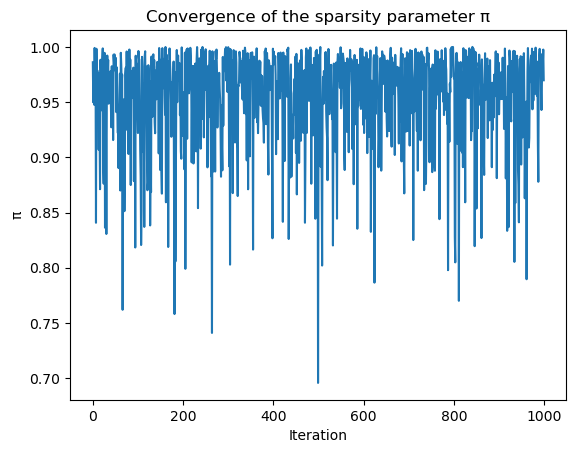

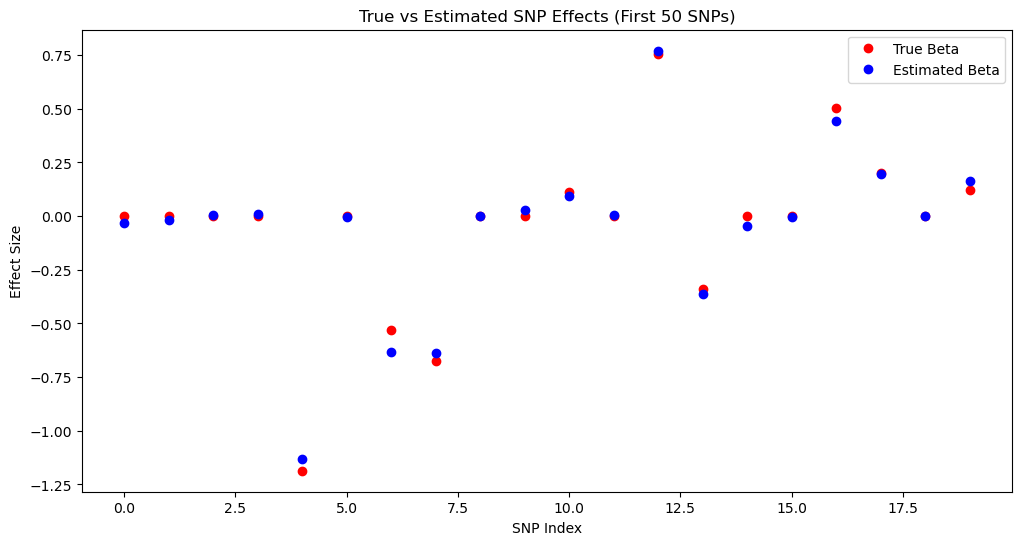

In [61]:
# 绘制稀疏性参数 pi 的收敛情况
plt.plot(pi_samples)
plt.title("Convergence of the sparsity parameter π")
plt.xlabel("Iteration")
plt.ylabel("π")
plt.show()

# 绘制真实和估计的 SNP 效应参数对比
plt.figure(figsize=(12, 6))
plt.plot(true_beta, 'ro', label="True Beta")
plt.plot(estimated_beta, 'bo', label="Estimated Beta")
plt.legend()
plt.xlabel("SNP Index")
plt.ylabel("Effect Size")
plt.title("True vs Estimated SNP Effects (First 50 SNPs)")
plt.show()


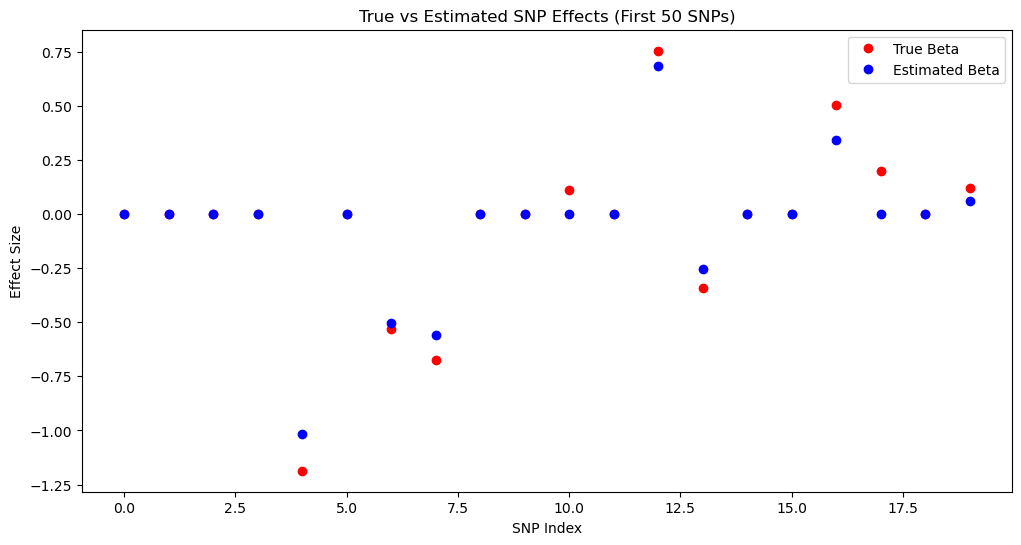

In [62]:
# 利用一般的lasso回归构建模型
from sklearn.linear_model import Lasso

# Apply Lasso regression from sklearn
lasso_model = Lasso(alpha=0.1, max_iter=10000)  # Using L1 regularization
lasso_model.fit(X[:, :n_snps], y)

# Estimate beta coefficients from Lasso
estimated_beta_lasso = lasso_model.coef_

# Compare the true and estimated beta for the first 10 SNPs
# true_beta[:10], estimated_beta_lasso[:10]
plt.figure(figsize=(12, 6))
plt.plot(true_beta, 'ro', label="True Beta")
plt.plot(estimated_beta_lasso, 'bo', label="Estimated Beta")
plt.legend()
plt.xlabel("SNP Index")
plt.ylabel("Effect Size")
plt.title("True vs Estimated SNP Effects (First 50 SNPs)")
plt.show()